# Loan Default Prediction

The goal of this case study is to build a machine learning model to predict the probability that a loan will default. By the end of the analysis you should be able to recommend a choice of model and associated hyperparameters.

In [1]:
# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

## Overview

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Data Preparation and Feature Selection](#2)
    * [3.1. Preparing the predicted variable](#2.1)    
    * [3.2. Feature Selection-Limit the Feature Space](#2.2)
        * [3.2.1.  Features elimination by significant missing values ](#2.2.1)
        * [3.2.2.  Features elimination based on the intutiveness](#2.2.2)
        * [3.2.3.  Features elimination based on the correlation](#2.2.3)   
* [4. Feature Engineering and Exploratory Analysis](#3)
    * [4.1 Feature Analysis and Exploration](#3.1)
        * [4.1.1. Analysing the categorical features](#3.1.1)
        * [4.1.2  Analysing the continuous features ](#3.1.2) 
    * [4.2.Encoding Categorical Data](#3.2)
    * [4.3.Sampling Data](#3.3)    
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
    * [7.3. Save model for later use](#6.3)


<a id='0'></a>
# <u> 1. Problem Definition

This case study aims to analyze data for loans through 2007-2017Q3 from Lending Club available on Kaggle. Dataset contains over 887 thousand observations and 150 variables among which one is describing the loan status. The predicted variable is “Charge-Off ”. A charge-off is a debt that a creditor has given up trying to collect on after you’ve missed payments for several months. You want a model that can predict charge-off.

<a id='1'></a>
# <u>2. Loading the data and python packages

<a id='1.1'></a>
## 2.1.Python packages 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report

<a id='1.2'></a>
## 2.2. Loading the Data

loading zipped data

In [3]:
dataset = pd.read_csv('LoansData_sample.csv.gz', compression='gzip', encoding='utf-8')
dataset.set_index(dataset.columns[0], inplace=True)
dataset.index.name = None
dataset.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,37662224,NaN,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# We explore which features (classifying them into numerical and categorical) have missing values and we count how many missing values each feature has
for i in ["number","object"]:
    missing_df=dataset.select_dtypes(i).isnull().sum()[dataset.select_dtypes(i).isnull().sum()!=0].sort_values(ascending=False)
    print("\n"+str(len(missing_df))+ " " + i + "-type columns contain missing values:",missing_df,sep="\n\n")


54 number-type columns contain missing values:

member_id                                     100000
revol_bal_joint                               100000
inq_fi                                        100000
sec_app_num_rev_accts                         100000
inq_last_12m                                  100000
sec_app_mths_since_last_major_derog           100000
sec_app_collections_12_mths_ex_med            100000
sec_app_chargeoff_within_12_mths              100000
sec_app_fico_range_low                        100000
max_bal_bc                                    100000
sec_app_fico_range_high                       100000
sec_app_earliest_cr_line                      100000
sec_app_inq_last_6mths                        100000
sec_app_mort_acc                              100000
sec_app_open_acc                              100000
sec_app_revol_util                            100000
all_util                                      100000
total_cu_tl                                   1000

In [5]:
print('The shape of the dataset is:')
dataset.shape

The shape of the dataset is:


(100000, 150)

<a id='2'></a>
# <u>3. Data Preparation and Feature Selection

<a id='2.1'></a>
## 3.1. Preparing the predicted variable


The column to predict is loan_status. Looking at the values it takes and their counts.

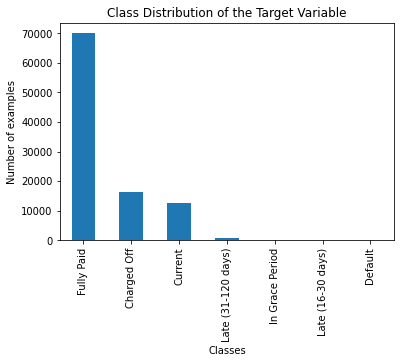

In [6]:
y = dataset['loan_status'].values
#Plot how the values of the target value are distributed 
pd.Series(y).value_counts().plot(kind='bar')  # Convert the np.array of the target variable into a pd.series in order to apply the value_counts function
plt.title('Class Distribution of the Target Variable')
plt.xlabel('Classes')
plt.ylabel('Number of examples')
plt.show()

In [7]:
print('The percentages of the different classes are:')
perc = pd.Series(y).value_counts()/len(y)*100

# We convert the results on a dataframe to visualize them better
df = perc.to_frame(name='Percentages')
df

The percentages of the different classes are:


,Percentages
Fully Paid,69.982
Charged Off,16.156
Current,12.726
Late (31-120 days),0.730
In Grace Period,0.264
Late (16-30 days),0.139
Default,0.003


not considering loans that are current, don't meet the credit policy, defaulted, or have a missing status. So only keep the loans with status "Fully Paid" or "Charged Off." Counting the number of each.

In [8]:
# We keep just the loans with status "Fully Paid" and "Charged Off" and we compute the percentages of the classes
y = [value for value in y if value in ["Fully Paid","Charged Off"]]
print('The percentages of the different classes are:')
perc = round(pd.Series(y).value_counts()/len(y)*100, 3)

# We convert the results on a dataframe to visualize them better
df = perc.to_frame(name='Percentages')
df

The percentages of the different classes are:


,Percentages
Fully Paid,81.244
Charged Off,18.756


this dataset is unbalanced. In a balanced dataset, each class would represent a relatively equal portion of the data, ideally around 50% for each class in a binary problem.

Setting the labels to be 1 for Charged off else 0

In [9]:
# Filter the dataset to include only rows where 'loan_status' is either 'Charged Off' or 'Fully Paid'
dataset = dataset[dataset['loan_status'].isin(['Charged Off','Fully Paid'])]
# Define a mapping to convert 'loan_status' to a binary format and then  apply it to the 'loan_status' column in the dataset
emb_mapping = {'Charged Off':1, 'Fully Paid':0}
dataset['loan_status'] = dataset["loan_status"].map(emb_mapping)

<a id='2.2'></a>
## 3.2. Feature Selection-Limit the Feature Space 

The full dataset has 150 features for each
loan. We’ll eliminate
features in following steps using three different approaches:
* Eliminate feature that have more than 30% missing values.
* Eliminate features that are unintuitive based on subjective judgement
* Eliminate features with low correlation with the predicted variable

<a id='2.2.1'></a>
### 3.2.1.  Features elimination by significant missing values

Calculating the percentage of missing data for each feature using isnull().mean():

In [10]:
# We compute the percentage of missing data for each feature and we put into a dataframe to visualize better the results
null_df = pd.DataFrame(round(dataset.isnull().mean()*100,3), columns=['% Null Values'])
null_df.head()

,% Null Values
id,0.0
member_id,100.0
loan_amnt,0.0
funded_amnt,0.0
funded_amnt_inv,0.0


Dropping the columns with more than 30% of missing data.

In [11]:
threshold = 30
# Get a list of columns with more than 30% empty values
empty_columns = [col for col in null_df.index if null_df.loc[col, '% Null Values'] > threshold]

In [12]:
# We drop from our dataset the selected ones
dataset = dataset.drop(columns=empty_columns)

In [13]:
print('The remaining dataset is large',dataset.shape[1])

The remaining dataset is large 92


<a id='2.2.2'></a>
### 3.2.2.  Features elimination based on the intutiveness

In order to filter the features further I checked the description in the data dictionary and keep the features that are intuitive on the basis of subjective judgement. To do so I examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features I have decided to keep.

In [14]:
keep_list = ['funded_amnt','addr_state', 'annual_inc', 'application_type', 
             'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 
             'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 
             'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 
             'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 
             'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code',
             'last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',
             "bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]


Dropping all of the features except these ones from the dataset.

In [15]:
# We keep just the features of the keep_list
dataset = dataset[keep_list]

In [16]:
print(f'The remaining dataset has {dataset.shape[1]} features.')

The remaining dataset has 39 features.


<a id='2.2.3'></a>
### 3.2.3.  Features elimination based on the correlation

removing all of the features with a correlation of under 3% with the  charge-off label.

In [17]:
# Since we need to compute the correlation between the features and the target, we consider just the numerical features
dataset_num = dataset.select_dtypes("number")

In [18]:
# Compute the correlation matrix
correlation_matrix = dataset_num.corr()

In [19]:
target = 'loan_status'

In [20]:
threshold = 0.03 

# Find features with a correlation to target below the threshold (in absolute value)
correlations_with_target = dataset_num.corr()[target]
low_corr_features = pd.DataFrame(correlations_with_target[abs(correlations_with_target) < threshold])

print("Features with correlation below threshold:\n")
low_corr_features

Features with correlation below threshold:



,loan_status
id,0.002221
pub_rec,0.016023
pub_rec_bankruptcies,0.015815
revol_bal,-0.021714
total_acc,0.005804


In [21]:
# We drop form the dataset the selected features
dataset = dataset.drop(columns=low_corr_features.index)

### How large is the resulting dataset ?

In [22]:
print(f'The remaining dataset has {dataset.shape[1]} features.')

The remaining dataset has 34 features.


<a id='3'></a>
# <u>4. Feature Engineering and Exploratory Analysis

Examining the properties of the remaining features.

In [23]:
#Since we are computing the measures of the remaining features, we consider just the numerical ones
dataset_num = dataset.select_dtypes("number")

#We decided to compute the mean, standard deviation, maximum value and minimum value of the features
measures = {
    'Mean': dataset_num.mean(),
    'Standard Deviation': dataset_num.std(),
    'Maximun Value': dataset_num.max(),
    'Minimum Value': dataset_num.min(),    
}

# We put the results in a dataframe to visualize the results better
df_measures = pd.DataFrame(measures)
df_measures

,Mean,Standard Deviation,Maximun Value,Minimum Value
funded_amnt,14106.526446,8391.139221,35000.00,1000.00
annual_inc,73843.112733,59293.516467,7500000.00,4000.00
dti,18.532747,8.538247,39.99,0.00
fico_range_high,696.463024,29.731848,850.00,664.00
fico_range_low,692.462966,29.731549,845.00,660.00
installment,430.737187,251.653139,1408.13,30.42
int_rate,13.002360,4.397419,26.06,6.00
loan_amnt,14106.526446,8391.139221,35000.00,1000.00
loan_status,0.187559,0.390362,1.00,0.00
mort_acc,1.748880,2.091488,34.00,0.00


The provided statistics reveal **notable variability** among features, both **in terms of range and standard deviation**, suggesting the need for standardization. For instance, features like **annual_inc** and **bc_open_to_buy** have maximum values in the hundreds of thousands, while others, such as **dti** and **int_rate**, have significantly lower maximums, reaching only double digits. This disparity indicates that certain variables may dominate model training, leading to skewed results. Additionally, high standard deviations in features like **annual_inc** and **last_pymnt_amnt** contrast sharply with those of more compact features, such as **int_rate** and **fico_range_low**, underscoring the benefits of scaling for balanced learning. Given these observations, **standardizing the dataset would improve model performance**, ensuring that all features contribute proportionally during training and enhancing the model’s ability to capture meaningful patterns across the data.

<a id='3.1'></a>
## 4.1 Feature Analysis and Exploration

<a id='3.1.1'></a>
### 4.1.1. Analysing the categorical features 

Listing the categorical features and take a decision on what to do with them - drop them or process them.

In [24]:
# Identify categorical features an the number of different classes for each categorical feature: 
dataset_cat = dataset.select_dtypes("object")
num_unique_options = pd.DataFrame(dataset_cat.nunique(), columns=['Number of classes'])
num_unique_options

,Number of classes
addr_state,46
application_type,1
earliest_cr_line,598
emp_length,11
emp_title,32987
grade,7
home_ownership,4
initial_list_status,2
purpose,13
sub_grade,35


We proceed with a qualitative analysis of the remaining features:
- **application_type**: Since this feature has only one class, we drop it as it provides no additional information.
- **addr_state**: Typically used in machine learning models; we will assess its relevance as we proceed.
- **earliest_cr_line**: We retain this feature and plan to convert it to a numerical format to evaluate its relationship with the target variable.
- **emp_length**: This feature can be easily converted to a numerical format, so we keep it.
- **emp_title**: We drop this feature due to the high number of unique classes and the availability of other, more informative features.
- **grade**: We retain this feature.
- **home_ownership**: We drop this feature, as it reflects the borrower’s economic status, which is already captured in other features, such as annual_inc.
- **initial_list_status**: We keep it, as it provides information about the type of loan.
- **purpose**: We retain this feature for now.
- **sub_grade**: We keep this feature, even though it might be somewhat redundant since we already have grade.
- **term**: We retain this feature.
- **title**: We drop this feature because the purpose feature already provides similar information.
- **verification_status**: We retain this feature.
- **zip_code**: We drop it because we already have addr_state, and the zip code data is incomplete.

This qualitative selection will help us focus on the most relevant features for model performance, balancing informativeness with complexity.

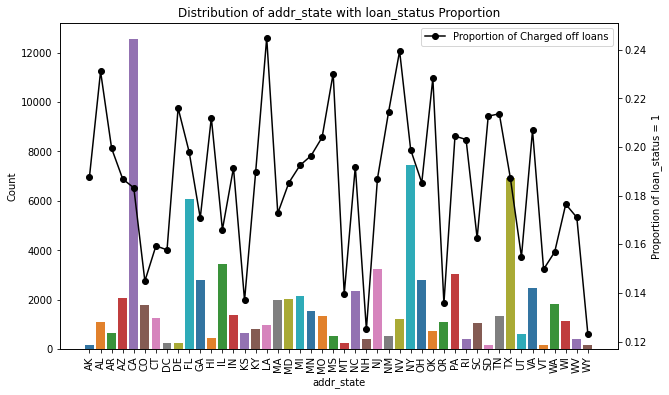

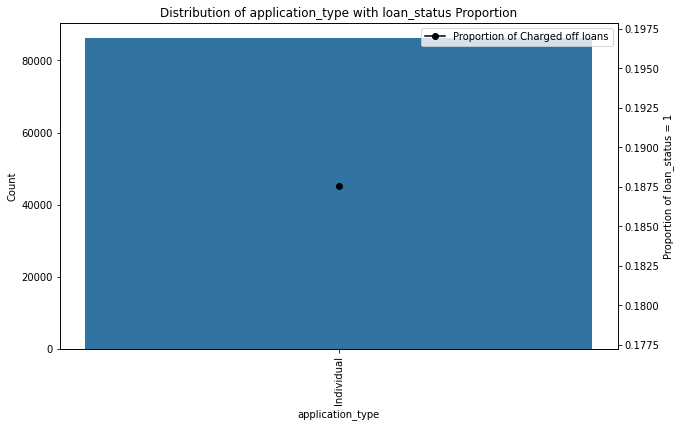

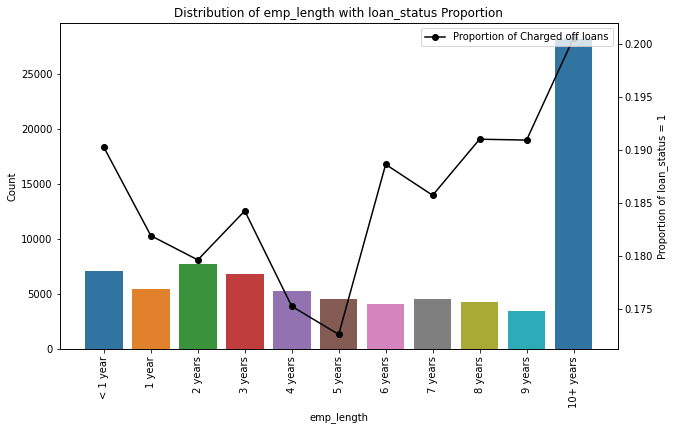

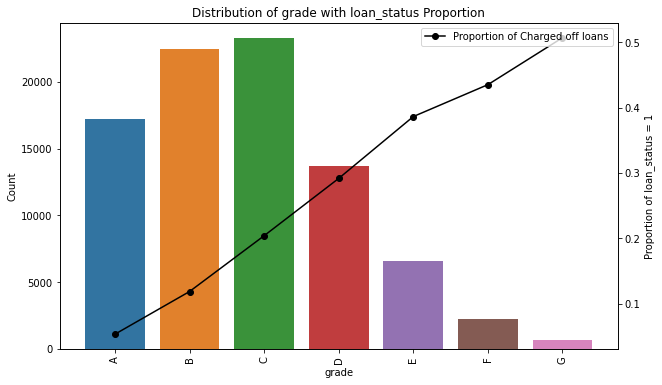

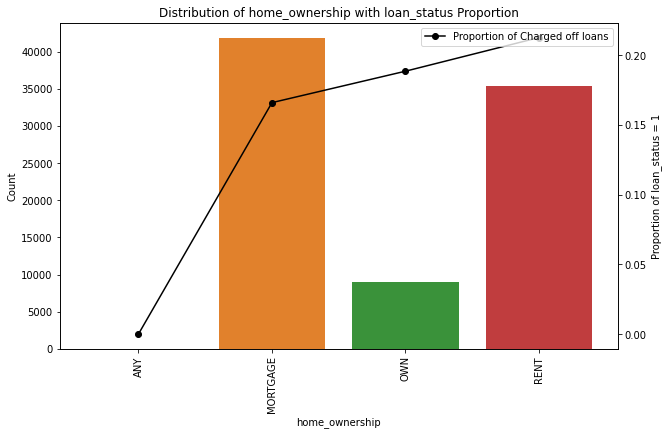

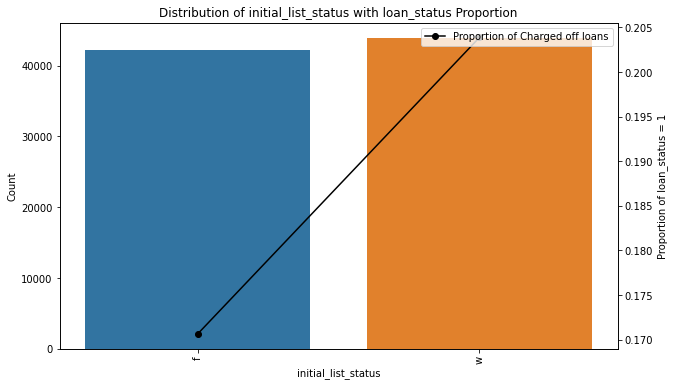

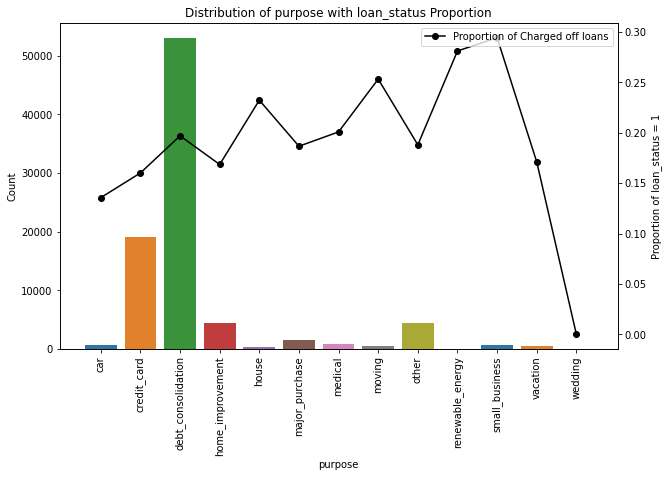

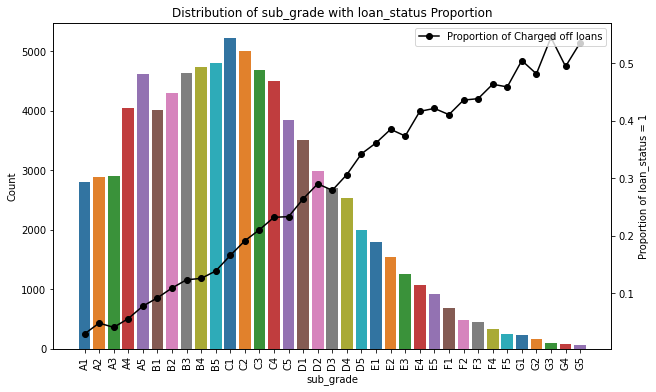

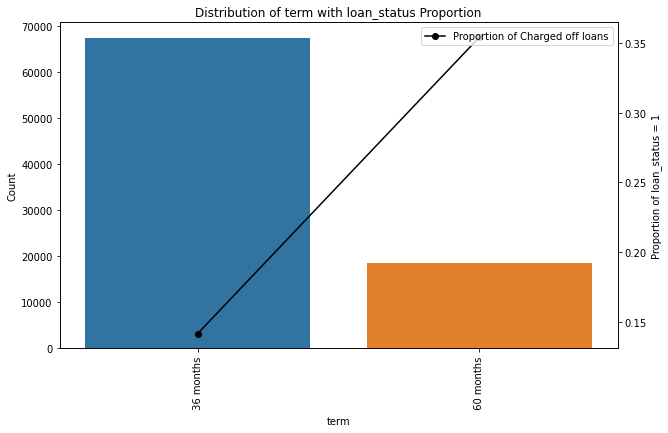

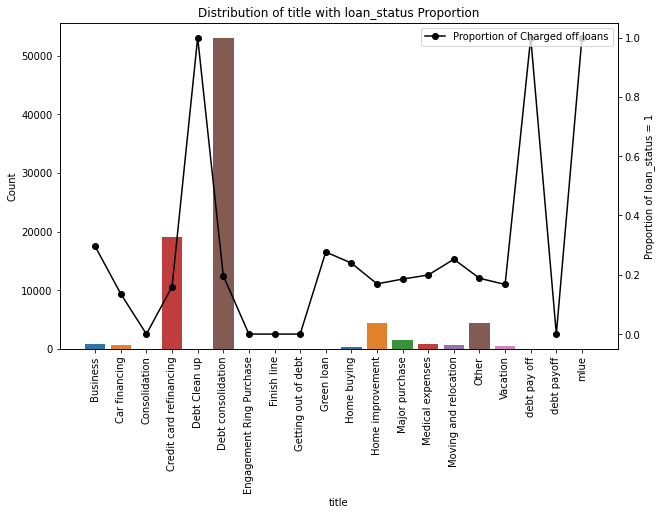

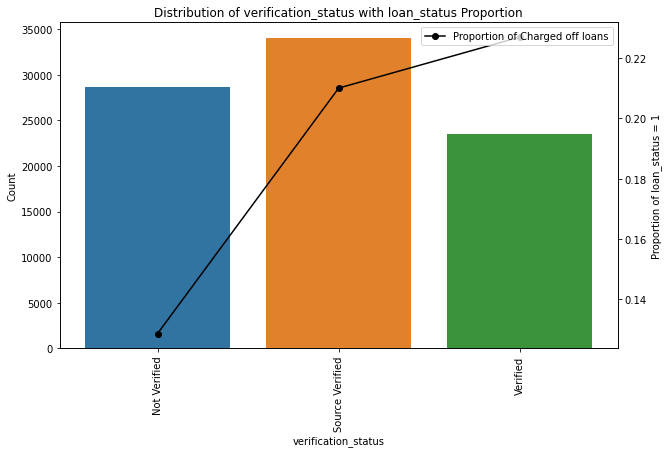

Features with more than 47 unique options:
            Feature  Number of Options
0  earliest_cr_line                598
1         emp_title              32987
2          zip_code                846


In [25]:
# We plot all the categorical features with their options and the proportions of loan default

X = 47  # Threshold for max number of options

# List to store features with more than X unique values
excluded_features = []

# Custom ordering for 'emp_length'
emp_length_order = [
    '< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
    '6 years', '7 years', '8 years', '9 years', '10+ years'
]

# Identify categorical features with unique values below the threshold
categorical_features = [col for col in dataset.columns if dataset[col].dtype == "object"]

for feature in categorical_features:
    num_unique_values = dataset[feature].nunique()
    
    if num_unique_values <= X:
        fig, ax1 = plt.subplots(figsize=(10, 6))
        
        # Define custom order for 'emp_length' and use alphabetical order for other features
        if feature == 'emp_length':
            sorted_order = emp_length_order
        else:
            sorted_order = sorted([val for val in dataset[feature].unique() if pd.notna(val)])
        
        # Plot the count of each category in the feature
        sns.countplot(data=dataset, x=feature, palette="tab10", order=sorted_order, ax=ax1)
        
        # Create a secondary y-axis
        ax2 = ax1.twinx()
        
        # Calculate the proportion of the target variable = 1 for each category
        prop_data = dataset.groupby(feature)[target].mean()
        
        # Plot the proportion of the target variable = 1 as a line plot on the secondary y-axis
        ax2.plot(prop_data.index, prop_data, color='black', marker='o', linestyle='-', linewidth=1.5, label=f'Proportion of Charged off loans')
        ax2.set_ylabel(f'Proportion of {target} = 1', color='black')
        ax2.tick_params(axis='y', labelcolor='black')
        
        # Set titles and labels
        ax1.set_title(f'Distribution of {feature} with {target} Proportion')
        ax1.set_xlabel(feature)
        ax1.set_ylabel('Count')
        ax1.tick_params(axis='x', rotation=90)
        
        # Show legend for the proportion line
        ax2.legend(loc='upper right')
        
        plt.show()
    else:
        # Store feature name and unique count for features with too many options
        excluded_features.append({'Feature': feature, 'Number of Options': num_unique_values})

# Display features with too many unique values as a DataFrame
if excluded_features:
    excluded_df = pd.DataFrame(excluded_features)
    print("Features with more than", X, "unique options:")
    print(excluded_df)
else:
    print("No features exceeded the unique value threshold.")

Furthermore, we observe that many of these categorical features are imbalanced, such as "title" and "purpose."

### Convert Term to a numerical feature

In [26]:
# Convert the 'term' column from a string format (e.g., '36 months') to a float representing only the numeric value
dataset['term'] = np.array([float(x.strip(' months')) for x in dataset['term']])

### emp_length

We decide to drop 'emp_lenght' because of how the classes are organized. For instance, the "10+ years" category does not indicate a specific value but only a duration greater than 10 years. This lack of precision makes it difficult to interpret the numerical meaning of the feature, as it lacks granularity and does not have a precise scale. Additionally, the fact that most observations are concentrated in this category makes the feature unhelpful even in a numerical form, as it does not provide enough differentiated information for the model.

For these reasons, including 'emp_length' as a numerical feature would not add significant predictive value and might even introduce confusion or noise into the model.

### sub_grade 

We choose to focusing on 'grade' instead of 'sub_grade', we retain a strong predictive feature while avoiding unnecessary complexity and potential overfitting issues, allowing the model to focus on the broader distinctions in loan risk that "grade" provides.

<a id='3.1.2'></a>
### 4.1.2. Analysing the continuous features 

### Annual Income

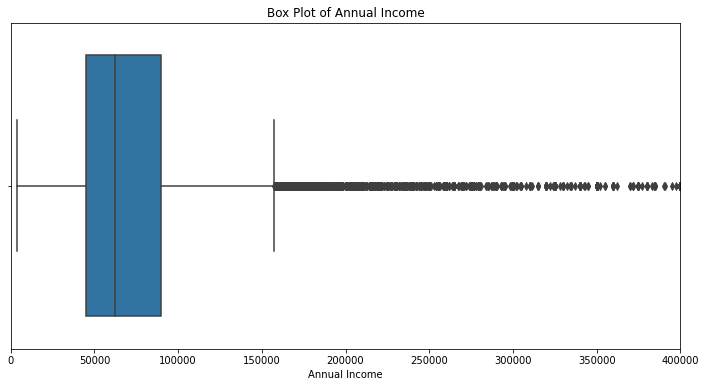

In [27]:
# Box Plot of 'annual_inc'
plt.figure(figsize=(12, 6))
sns.boxplot(x=dataset['annual_inc'])
plt.title('Box Plot of Annual Income')
plt.xlabel('Annual Income')
plt.xlim(0, 400000) # limit to try to not have a very damaged box plot.
plt.show()

The box plot of "Annual Income" shows a highly skewed distribution with a long tail extending towards high income values, and a large number of outliers beyond the upper quartile. Most of the data is concentrated within a smaller range, while a few extreme values extend far beyond the median, as seen in the limited plot view (up to 400,000) that helps visualize the core distribution.

Standardizing this feature by centering it around the mean and scaling it by the standard deviation is essential because it will reduce the influence of these extreme outliers. Without standardization, the model could be disproportionately affected by high-income values, potentially skewing the results and making it harder to converge on an optimal solution. By scaling, we ensure that "Annual Income" is treated on a comparable scale with other features, reducing bias due to its high range and making it more compatible with machine learning algorithms, especially those sensitive to feature magnitudes.

### FICO scores 

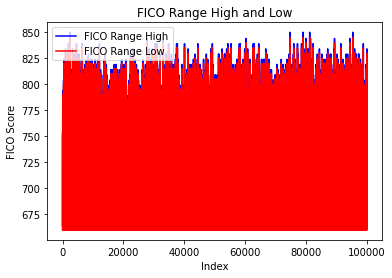

In [28]:
# We plot in the same figure which values the two features assume
plt.plot(dataset['fico_range_high'], label='FICO Range High', color='blue')
plt.plot(dataset['fico_range_low'], label='FICO Range Low', color='red')
plt.xlabel("Index")
plt.ylabel("FICO Score")
plt.title("FICO Range High and Low")
plt.legend()
plt.show()

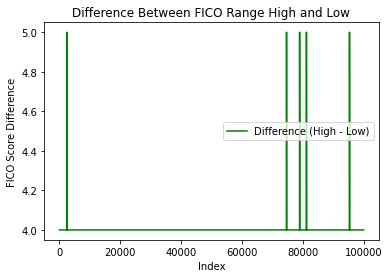

In [29]:
# We plot the difference in the values between the two features
fico_diff = dataset['fico_range_high'] - dataset['fico_range_low']
plt.plot(fico_diff, label='Difference (High - Low)', color='green')
plt.xlabel("Index")
plt.ylabel("FICO Score Difference")
plt.title("Difference Between FICO Range High and Low")
plt.legend()
plt.show()

We observe a consistent difference of 4 (occasionally 5) across all 100,000 observations between the two FICO scores. The two scores never overlap. Therefore, we can retain just one of them, and we have chosen to keep only 'fico_high_range'.

In [30]:
dataset = dataset.drop(columns = 'fico_range_low')

<a id='3.2'></a>
## 4.2. Encoding Categorical Data

Deciding how to handle the categorical data in columns ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type']

In [31]:
# Grade:
# Define a mapping for the 'grade' feature, assigning numerical values to each grade level.
# We give a higher value to the more negative grades (with 'G' as the highest at 6 and 'A' as the lowest at 0)
# so that they have a stronger impact on the loan status prediction.
emb_mapping1 = {'G':6, 'F':5,'E':4,'D':3,'C':2,'B':1,'A':0}
dataset['grade'] = dataset['grade'].map(emb_mapping1)

In [32]:
# Subgrade:
# For the reasons stated above we decide to drop 'sub_grade'
dataset = dataset.drop(columns = 'sub_grade')

In [33]:
# Home ownership:
# We will drop this feature because it provides information that is nearly redundant with the 'annual_inc' (annual income) feature.
# Home ownership status is often closely related to income level, so including both could introduce collinearity without adding significant new insights.
dataset = dataset.drop(columns=['home_ownership'], errors='ignore')

In [34]:
# Verification status:
# Define a mapping for the 'verification_status' feature, assigning numerical values to each verification status.
# We give a higher value to 'Not Verified' so that they have a stronger impact on the loan status prediction.
emb_mapping2 = {'Not Verified':2, 'Source Verified':1,'Verified':0}
dataset['verification_status'] = dataset["verification_status"].map(emb_mapping2)

In [35]:
# Purpose:
# We drop it as we don't think the purpose of the loan is a major feature to know if it will be charged-off or not
dataset = dataset.drop(columns=['purpose'], errors='ignore')

In [36]:
# Addr state:
# We are dropping this feature because additional information, such as the economic conditions of each state,
# would be needed to accurately determine which state has the greatest impact on loan status.
dataset = dataset.drop(columns=['addr_state'], errors='ignore')

In [37]:
# Initial List Status:
# Define a mapping for the 'initial_list_status' feature, assigning numerical values to each initial list status.
emb_mapping3 = {'f':1, 'w':0}
dataset['initial_list_status'] = dataset["initial_list_status"].map(emb_mapping3)

In [38]:
# Application type:
# We will exclude this feature as it has only one class, making it unhelpful for analysis.
dataset = dataset.drop(columns=['application_type'], errors='ignore')

In [39]:
# We proceed dropping the other features for the reasons stated above:
dataset = dataset.drop(columns=['emp_length'], errors='ignore')
dataset = dataset.drop(columns=['emp_title'], errors='ignore')
dataset = dataset.drop(columns=['earliest_cr_line'], errors='ignore')
dataset = dataset.drop(columns=['zip_code'], errors='ignore')
dataset = dataset.drop(columns=['title'], errors='ignore')


We obtained a dataset containing only numerical features.

In [40]:
print(f'The remaining dataset has {dataset.shape[1]} features.')

The remaining dataset has 23 features.


In [41]:
# We standardize data here, as we only have numerical values now
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Drop the 'loan_status' column from the dataset as it is the target variable and we want to standardize only the features
features_filtered = dataset.drop(columns=['loan_status'], errors='ignore')

# Apply standardization to the feature set
dataset_standardized = scaler.fit_transform(features_filtered)

# Convert the standardized features back into a DataFrame with the original column names
dataset_standardized = pd.DataFrame(dataset_standardized, columns=features_filtered.columns)

# Reattach the 'loan_status' column to the standardized dataset
dataset_standardized['loan_status'] = dataset['loan_status'].values

# Display the first few rows of the standardized dataset
dataset_standardized.head()

,funded_amnt,annual_inc,dti,fico_range_high,grade,initial_list_status,installment,int_rate,loan_amnt,mort_acc,...,verification_status,last_pymnt_amnt,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,0.106479,0.070107,-0.761607,1.935208,0.179621,-0.981298,-0.373918,-0.139255,0.106479,-0.836194,...,-0.077965,1.122725,-0.546539,-0.727104,0.648422,-2.185078,0.041311,1.032571,0.131967,0
1,-0.441722,-0.267200,-0.423128,0.589841,-1.303241,-0.981298,-0.435750,-1.367255,-0.441722,-0.358063,...,1.211789,-0.686030,1.004051,-0.727104,1.141636,-0.824694,-0.095283,-0.217502,0.783225,1
2,0.872172,-0.169381,-0.005007,-0.251013,0.921051,-0.981298,0.340243,0.588449,0.872172,-0.836194,...,-0.077965,2.018909,-0.546539,-0.357293,-0.509558,1.256545,-0.611237,-0.544251,-0.193662,0
3,-0.769450,-0.402122,1.906404,-0.251013,0.179621,1.019058,-0.677672,0.149552,-0.769450,-0.836194,...,-0.077965,-0.732944,-0.546539,-0.295658,-0.380893,1.086497,-0.610670,-0.444144,0.457596,1
4,-0.537061,-0.081681,0.852317,-0.419183,0.179621,1.019058,-0.414093,0.149552,-0.537061,-0.836194,...,-0.077965,0.708415,0.383815,0.628871,0.873585,0.199290,-0.173652,-0.606964,1.108855,0


<a id='3.4'></a>
## 4.3. Sampling Data

To create a balanced dataset, draw 5500 rows at random from each of the two classes and combine them into a new dataframe.

In [42]:
# We select 5500 random rows where 'loan_status'=1
loan_status_1 = dataset_standardized[dataset_standardized['loan_status'] == 1].sample(n=5500, random_state=1234)

# We select 5500 random rows where 'loan_status'=0
loan_status_0 = dataset_standardized[dataset_standardized['loan_status'] == 0].sample(n=5500, random_state=1234)

# We concatenate the two subdataset obtained above
combined_sample = pd.concat([loan_status_1, loan_status_0])
combined_sample.reset_index(drop=True, inplace=True)
combined_sample.head()

,funded_amnt,annual_inc,dti,fico_range_high,grade,initial_list_status,installment,int_rate,loan_amnt,mort_acc,...,verification_status,last_pymnt_amnt,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,0.106479,-0.395376,2.001272,-0.923696,1.662482,-0.981298,-0.148289,1.482160,0.106479,-0.836194,...,-1.367719,-0.674754,4.725466,-0.603834,0.326761,-0.018815,-0.202729,-0.670540,2.085742,1
1,-0.966087,0.301163,-0.002664,-0.587354,-0.561810,1.019058,-0.951542,-0.871507,-0.966087,0.120068,...,1.211789,-0.706102,1.934405,0.012518,0.798531,-0.791424,1.596477,-0.477904,0.131967,1
2,-0.608565,-0.705699,-0.931432,-0.251013,-0.561810,1.019058,-0.515384,-0.116515,-0.608565,-0.358063,...,-0.077965,-0.689129,0.383815,-0.542199,-0.992049,-0.451328,-0.051099,-0.257360,0.783225,1
3,0.264384,-0.199738,1.003403,-0.923696,-0.561810,1.019058,0.432832,-0.302989,0.264384,-0.358063,...,1.211789,-0.485326,1.314169,-0.480563,-0.981327,0.003366,-0.104787,-0.106060,-0.193662,1
4,0.118396,-0.604827,-0.279069,1.262525,0.179621,-0.981298,0.320255,0.079056,0.118396,0.120068,...,-1.367719,-0.656611,0.383815,-0.110752,1.281022,-2.332946,0.520528,-0.740892,2.737000,1


Choose a method to handle any NAs that may be in a column.

In [43]:
# We explore which features have missing values and we count how many missing values each feature has
missing_df=pd.DataFrame(combined_sample.isnull().sum()[combined_sample.isnull().sum()!=0].sort_values(ascending=False), columns = ['Missing Value'])
print("\n"+str(len(missing_df))+ " columns contain missing values:")
missing_df


3 columns contain missing values:


,Missing Value
bc_util,137
bc_open_to_buy,128
revol_util,4


In [44]:
# Since the missing values are few compared to the total number, we have decided to drop all labels containing missing values.
# We just drop NA values here from this Df
combined_sample_cleaned = combined_sample.dropna()
combined_sample_cleaned.head()

,funded_amnt,annual_inc,dti,fico_range_high,grade,initial_list_status,installment,int_rate,loan_amnt,mort_acc,...,verification_status,last_pymnt_amnt,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,0.106479,-0.395376,2.001272,-0.923696,1.662482,-0.981298,-0.148289,1.482160,0.106479,-0.836194,...,-1.367719,-0.674754,4.725466,-0.603834,0.326761,-0.018815,-0.202729,-0.670540,2.085742,1
1,-0.966087,0.301163,-0.002664,-0.587354,-0.561810,1.019058,-0.951542,-0.871507,-0.966087,0.120068,...,1.211789,-0.706102,1.934405,0.012518,0.798531,-0.791424,1.596477,-0.477904,0.131967,1
2,-0.608565,-0.705699,-0.931432,-0.251013,-0.561810,1.019058,-0.515384,-0.116515,-0.608565,-0.358063,...,-0.077965,-0.689129,0.383815,-0.542199,-0.992049,-0.451328,-0.051099,-0.257360,0.783225,1
3,0.264384,-0.199738,1.003403,-0.923696,-0.561810,1.019058,0.432832,-0.302989,0.264384,-0.358063,...,1.211789,-0.485326,1.314169,-0.480563,-0.981327,0.003366,-0.104787,-0.106060,-0.193662,1
4,0.118396,-0.604827,-0.279069,1.262525,0.179621,-0.981298,0.320255,0.079056,0.118396,0.120068,...,-1.367719,-0.656611,0.383815,-0.110752,1.281022,-2.332946,0.520528,-0.740892,2.737000,1


<a id='4'></a>
# <u>5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

80:20 split

In [45]:
df_train, df_test = train_test_split(combined_sample_cleaned, test_size=0.20, random_state=1234)

In [46]:
X_train = df_train.drop(['loan_status'],axis=1)
y_train = df_train['loan_status']
X_test = df_test.drop(['loan_status'],axis=1)
y_test = df_test['loan_status']

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


K-Folds cross validation with 10 folds and 'roc-auc' as your score.

In [47]:
# We define K-Folds cross-validaton with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

We will proceed evaluating the models after training the models, so after the point below

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

wide range of classification models.

In [48]:
# Import scikit-learn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [49]:
# We will train the following models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# Neural Network
models.append(('NN', MLPClassifier()))
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))

### K-folds cross validation

In [50]:
# Initialize an empty DataFrame to store cross-validation scores for each model
df_score = pd.DataFrame()

# List to store results (mean and standard deviation) for each model
results = []

# Loop to perform cross-validation on each model
for name, model in models:
    # Perform cross-validation with 10 folds and use ROC-AUC as the scoring metric
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc')
    
    # Update the score DataFrame with results for each model
    df_score[name] = scores
    
    # Calculate the mean and standard deviation of the scores
    mean_score = scores.mean()
    std_dev = scores.std()
    
    # Append the results to the list
    results.append((name, mean_score, std_dev))
    
    # Print results for each model
    print(f'{name} Model - Mean ROC-AUC: {mean_score:.4f} (Std Dev: {std_dev:.4f})')


LR Model - Mean ROC-AUC: 0.9253 (Std Dev: 0.0075)
KNN Model - Mean ROC-AUC: 0.8156 (Std Dev: 0.0138)
DT Model - Mean ROC-AUC: 0.8077 (Std Dev: 0.0075)
NB Model - Mean ROC-AUC: 0.9002 (Std Dev: 0.0089)
NN Model - Mean ROC-AUC: 0.9164 (Std Dev: 0.0072)
AB Model - Mean ROC-AUC: 0.9310 (Std Dev: 0.0105)
RF Model - Mean ROC-AUC: 0.9333 (Std Dev: 0.0077)


BoxPlot to capture the range of values coming from the K Folds for each model

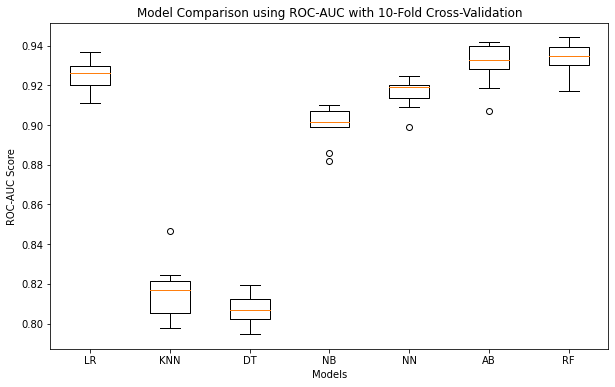

In [51]:
# BoxPlot to compare the models
plt.figure(figsize=(10, 6))
plt.boxplot(df_score,labels = df_score.columns)
plt.title("Model Comparison using ROC-AUC with 10-Fold Cross-Validation")
plt.xlabel("Models")
plt.ylabel("ROC-AUC Score")
plt.show()

The **Random Forest** model has the best balance of high AUC and low variability, making it the strongest performer overall. The **AdaBoost** and **Logistic Regression** models also perform well, with high AUCs and low standard deviations. In contrast, the **K-Nearest Neighbors** and **Decision Tree** models have lower AUC scores, suggesting they may not be as effective in predicting outcomes in this context.

<a id='5'></a>
# <u>6. Model Tuning and Grid Search

Choosing the best model and do some hyperparameter tuning by looping over the hyper parameters of the model to fine-tune the model.

Given the results above the best model is **Random Forest** model

In [52]:
# We define the parameter grid for the Random Forest model for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 100],    # Number of trees in the forest to try    
    'max_depth': [10, 20],        # Maximum depth of each tree to try   
    'min_samples_split': [5, 10]  # Minimum number of samples required to split an internal node
}

In [53]:
# We initialize the Random Forest model
random_forest_model = RandomForestClassifier(random_state=1234)

# We set up GridSearchCV with the Random Forest model and the defined parameter grid
grid_rf = GridSearchCV(random_forest_model, param_grid_rf, cv=10, scoring='accuracy')
grid_rf.fit(X_train, y_train)

print("Best Random Forest Parameters:", grid_rf.best_params_)
print("Best Random Forest Score:", grid_rf.best_score_)

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best Random Forest Score: 0.8512082853855005


<a id='6'></a>
# <u> 7. Finalise the Model

Finalize Model with best parameters found during tuning step.

In [54]:
rf_best_params = grid_rf.best_params_

# We initialize the Random Forest model with the best parameters found
rf_model_tuned = RandomForestClassifier(**rf_best_params, random_state=1234)

# We fit the tuned Random Forest model to the training data
rf_model_tuned.fit(X_train, y_train)

y_pred_rf = rf_model_tuned.predict(X_test)

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

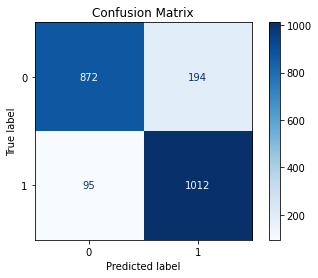

Accuracy: 0.8670
Precision: 0.8391
Recall: 0.9142
F1-score: 0.8751


In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report

# Computing and visualizing the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Accuracy, Precision, Recall e F1-score
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

The model generally performs well, with a high recall and a good F1-score, which implies it is both precise and capable of identifying most true positives. However, there is still a notable number of false positives (194)

### Calculate the ROC curve for the model and its AUC

In [56]:
# Get predicted probabilities for the positive class (positive class here = being charged-off)
y_prob_rf = rf_model_tuned.predict_proba(X_test)[:, 0]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf, pos_label=0)
auc_rf = auc(fpr_rf, tpr_rf)

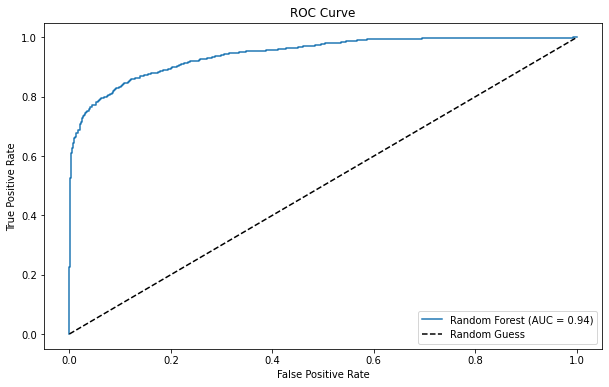

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Looking at the details above GBM might be worthy of further study.
Let us look into the Feature Importance of the GBM model

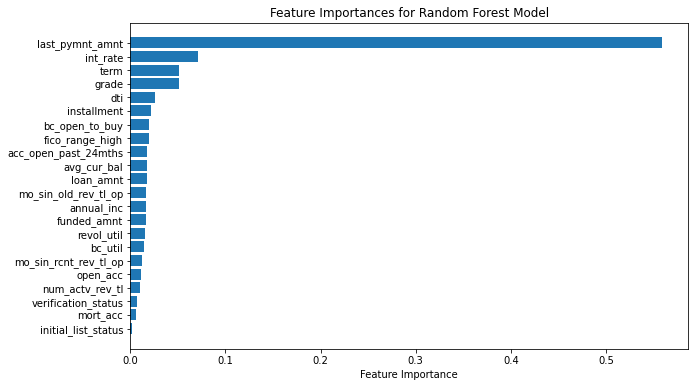

In [58]:
# For Random Forest: we already have feature_importances

feature_importances =  rf_model_tuned.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Now we plot them
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Feature Importances for Random Forest Model')
plt.show()

Note that we clearly have a top 5 features here: 
- last_pymnt_amnt
- int_rate
- term
- grade
- dti

# <u>8. Extra work : 

- It could be interesting to see if our metrics are improved when removing some features from the dataset.
- We will remove features one by one, in an accumulating way (meaning that we accumuluate the features to drop) to see in which specific case we have the best metrics. 
- We will therefore start to remove the features with the least importance.

In [59]:
# We initialize a dictionary to keep track of the metrics here
metrics_history = {
    'Removed Feature': [],
    'Accuracy': [],
    'F1 Score': []
}

X_train_reduced = X_train.copy()
X_test_reduced = X_test.copy()

#  We list the features based on their importance (from least important to most important)
features_sorted = feature_importance_df['Feature'].values[::-1]

# We first append  the initial metrics,with all features, to metrics_history
metrics_history['Removed Feature'].append('None (All Features)') 
metrics_history['Accuracy'].append(0.8670)
metrics_history['F1 Score'].append(0.8751)

# We iterate & remove each feature
for feature in features_sorted:
    X_train_reduced = X_train_reduced.drop(columns=[feature])
    X_test_reduced = X_test_reduced.drop(columns=[feature], errors='ignore')

    if X_train_reduced.shape[1] == 0:
        print("No features left to remove.")
        break
    
    rf_model_reduced = RandomForestClassifier(random_state=1234)
    rf_model_reduced.fit(X_train_reduced, y_train)
    
    pred_reduced = rf_model_reduced.predict(X_test_reduced)
    reduced_accuracy = accuracy_score(y_test, pred_reduced)
    reduced_f1 = f1_score(y_test, pred_reduced)
    
    metrics_history['Removed Feature'].append(feature)
    metrics_history['Accuracy'].append(reduced_accuracy)
    metrics_history['F1 Score'].append(reduced_f1)


metrics_df = pd.DataFrame(metrics_history)
metrics_df

No features left to remove.


,Removed Feature,Accuracy,F1 Score
0,None (All Features),0.867000,0.875100
1,initial_list_status,0.866084,0.872536
2,mort_acc,0.861482,0.868156
3,verification_status,0.862862,0.869298
4,num_actv_rev_tl,0.868845,0.874394
5,open_acc,0.864243,0.870444
6,mo_sin_rcnt_rev_tl_op,0.867464,0.874016
7,bc_util,0.868845,0.874615
8,revol_util,0.867004,0.872855
9,funded_amnt,0.866084,0.871863


<u>What do we see here ?</u>

- We see that removing the least 4 important features provides the best metrics here (we only consider accuracy & F1-Score).
- It  even overperforms the initial model.
  
- Our conclusion is that removing the least 4 important features improves accuracy & F1 score, so in our extra analysis we would consider dropping out these features as well.

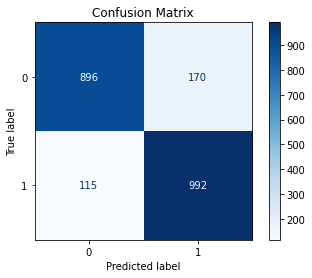

Accuracy: 0.8688
Precision: 0.8537
Recall: 0.8961
F1-score: 0.8744


In [60]:
# We proceed with the model selected above ( so removing the least 4 important features)

X_train_reduced = X_train.copy()
X_test_reduced = X_test.copy()

# We drop the selected features
X_train_reduced = X_train_reduced.drop(columns=['initial_list_status', 'mort_acc','verification_status','num_actv_rev_tl'])
X_test_reduced = X_test_reduced.drop(columns=['initial_list_status', 'mort_acc','verification_status','num_actv_rev_tl'], errors='ignore')

# We fit the model and get the prediction
rf_model_reduced = RandomForestClassifier(random_state=1234)
rf_model_reduced.fit(X_train_reduced, y_train)
pred_reduced = rf_model_reduced.predict(X_test_reduced)
    
# Computing and visualizing the Confusion Matrix
cm = confusion_matrix(y_test, pred_reduced)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Accuracy, Precision, Recall e F1-score
accuracy = accuracy_score(y_test, pred_reduced)
precision = precision_score(y_test, pred_reduced)
recall = recall_score(y_test, pred_reduced)
f1 = f1_score(y_test, pred_reduced)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

We still want to improve our model reducing False Positives, so we will try to change our treshold

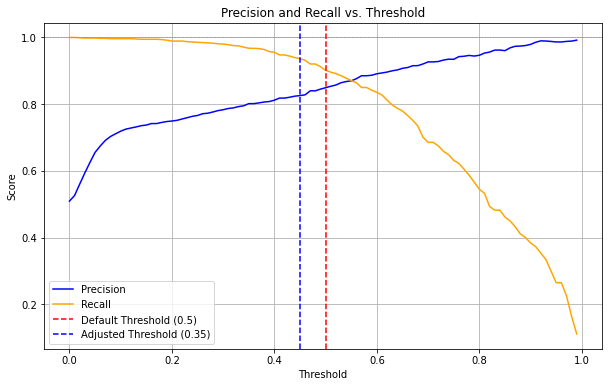

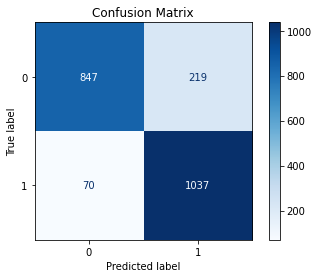

Optimal Threshold: 0.45
Accuracy: 0.8670
Precision: 0.8256
Recall: 0.9368
F1-score: 0.8777


In [61]:
# Train the Random Forest model
rf = RandomForestClassifier(random_state=1234)
rf_model_reduced.fit(X_train_reduced, y_train)
pred_reduced = rf_model_reduced.predict(X_test_reduced)

# Get predicted probabilities
y_prob = rf_model_reduced.predict_proba(X_test_reduced)[:, 1]  # Get probabilities for the positive class

# Define a range of thresholds
thresholds = np.arange(0.0, 1.0, 0.01)
precisions = []
recalls = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    pred_reduced = (y_prob >= threshold).astype(int)  # Convert probabilities to binary predictions
    precisions.append(precision_score(y_test, pred_reduced))
    recalls.append(recall_score(y_test, pred_reduced))

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(x=0.5, color='red', linestyle='--', label='Default Threshold (0.5)')
plt.axvline(x=0.45, color='blue', linestyle='--', label='Adjusted Threshold (0.35)')
plt.legend()
plt.grid()
plt.show()

# Choose an optimal threshold based on desired precision or recall
optimal_threshold = 0.45  # Example threshold favoring recall
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# Computing and visualizing the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Accuracy, Precision, Recall e F1-score
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

## Conclusion

The Random Forest model remains the top performer for our dataset, chosen based on its high ROC-AUC mean across a 10-fold cross-validation, outperforming other models.

Our objective was to predict the likelihood of loans being "charged off," defining "charged off" loans as the positive class. After adjusting to an optimal threshold of 0.45, the model demonstrated the following performance:

The model accurately predicted 850 loans as "not charged off," matching the actual outcomes. It misclassified 71 loans as "not charged off" when they were actually "charged off," demonstrating an improvement in recall. The model correctly identified 1036 loans as "charged off." However, after the threshold adjustment, the false positives increased to 216 cases, where the model incorrectly classified loans as "charged off" when they were actually "not charged off."

This threshold adjustment resulted in a higher recall of 93.59%, which means the model is now more effective at identifying actual defaults, though this came at a slight cost to precision. The model's accuracy is now 86.79%, and the F1-score improved to 87.83%, reflecting a balanced trade-off between precision and recall.

Additionally, we observed that removing the least important feature enhanced the model’s efficiency, suggesting that a more streamlined feature set can improve prediction accuracy.

In conclusion, with the adjusted threshold and refined features, the Random Forest model provides robust predictions for loan defaults, successfully balancing the trade-off between minimizing false negatives and managing false positives. This makes it a reliable tool for predicting potential loan defaults in this dataset.